Load & Visualize Data (EDA + Preprocessing)

In [ ]:
!pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"chandinimarrapu","key":"0542db9fc796f4245864b5a26701e050"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d manjilkarki/deepfake-and-real-images
!unzip -q deepfake-and-real-images.zip -d deepfake_data


Importing libraries

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tqdm import tqdm

Setting paths to dataset structure

In [ ]:
base_path = "/content/deepfake_data/Dataset"
train_path = os.path.join(base_path, "Train")
val_path = os.path.join(base_path, "Validation")
test_path = os.path.join(base_path, "Test")

IMG_SIZE = 128
BATCH_SIZE = 32

EDA (Exploratory Data Analysis)
➤ Count and Plot Image Distribution

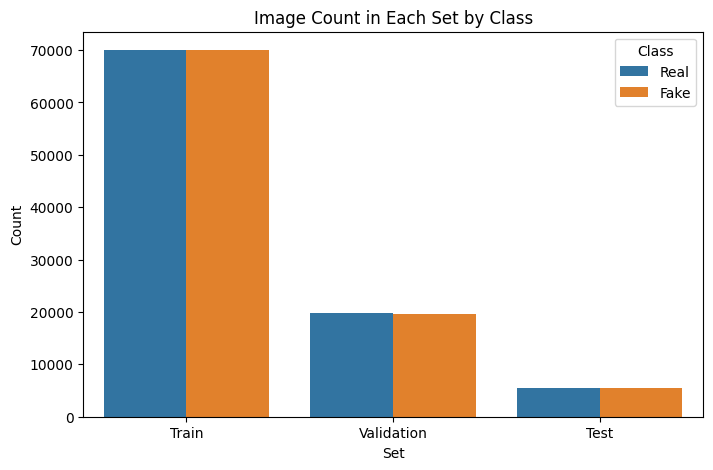

In [ ]:
def count_images(path):
    real = len(os.listdir(os.path.join(path, 'Real')))
    fake = len(os.listdir(os.path.join(path, 'Fake')))
    return real, fake

train_real, train_fake = count_images(train_path)
val_real, val_fake = count_images(val_path)
test_real, test_fake = count_images(test_path)

data = {
    'Set': ['Train', 'Train', 'Validation', 'Validation', 'Test', 'Test'],
    'Class': ['Real', 'Fake'] * 3,
    'Count': [train_real, train_fake, val_real, val_fake, test_real, test_fake]
}

import pandas as pd
df = pd.DataFrame(data)

# Bar plot
plt.figure(figsize=(8,5))
sns.barplot(x='Set', hue='Class', y='Count', data=df)
plt.title('Image Count in Each Set by Class')
plt.show()

Visualize Sample Images

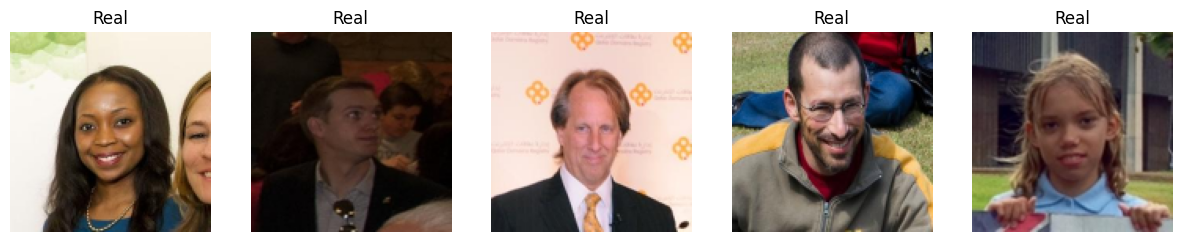

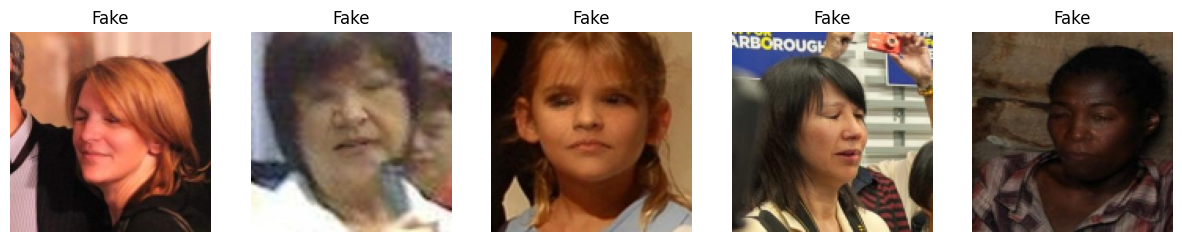

In [ ]:
def show_images(path, label, n=5):
    folder = os.path.join(path, label)
    plt.figure(figsize=(15,3))
    for i, img_name in enumerate(os.listdir(folder)[:n]):
        img = cv2.imread(os.path.join(folder, img_name))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (128, 128))
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(label)
    plt.show()

show_images(train_path, "Real")
show_images(train_path, "Fake")

Step 4: Preprocessing with ImageDataGenerator

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=10,
                                   zoom_range=0.1,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_data = train_datagen.flow_from_directory(train_path,
                                               target_size=(IMG_SIZE, IMG_SIZE),
                                               batch_size=BATCH_SIZE,
                                               class_mode='binary')

val_data = val_datagen.flow_from_directory(val_path,
                                           target_size=(IMG_SIZE, IMG_SIZE),
                                           batch_size=BATCH_SIZE,
                                           class_mode='binary')

test_data = test_datagen.flow_from_directory(test_path,
                                             target_size=(IMG_SIZE, IMG_SIZE),
                                             batch_size=BATCH_SIZE,
                                             class_mode='binary',
                                             shuffle=False)


Found 140002 images belonging to 2 classes.
Found 39428 images belonging to 2 classes.
Found 10905 images belonging to 2 classes.


Step 5: Model Creation

In [ ]:
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

Step 6: Train the Model

In [ ]:
history = model.fit(train_data,
                    validation_data=val_data,
                    epochs=10)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 688s 156ms/step - accuracy: 0.7807 - loss: 0.4407 - val_accuracy: 0.8785 - val_loss: 0.2816
Epoch 2/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 647s 148ms/step - accuracy: 0.9156 - loss: 0.2055 - val_accuracy: 0.9075 - val_loss: 0.2223
Epoch 3/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 649s 148ms/step - accuracy: 0.9292 - loss: 0.1757 - val_accuracy: 0.9268 - val_loss: 0.1879
Epoch 4/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 646s 148ms/step - accuracy: 0.9374 - loss: 0.1585 - val_accuracy: 0.9250 - val_loss: 0.1899
Epoch 5/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 648s 148ms/step - accuracy: 0.9416 - loss: 0.1467 - val_accuracy: 0.9316 - val_loss: 0.1757
Epoch 6/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 641s 147ms/step - accuracy: 0.9460 - loss: 0.1389 - val_accuracy: 0.9292 - val_loss: 0.1837
Epoch 7/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 659s 151ms/step - accuracy: 0.9471 - loss: 0.1305 - val_accuracy: 0.9369 - val_loss: 0.1700
Epoch 8/10
4376/4376 ━━━━━━━━━━━━━━━━━━━━ 641s 146ms/step - ac

 Step 7: Visualize Accuracy and Loss

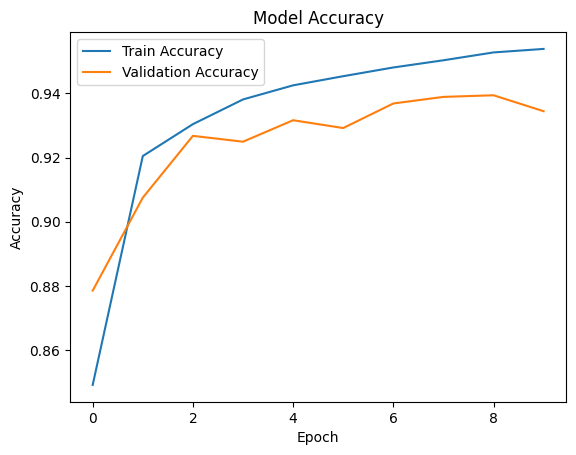

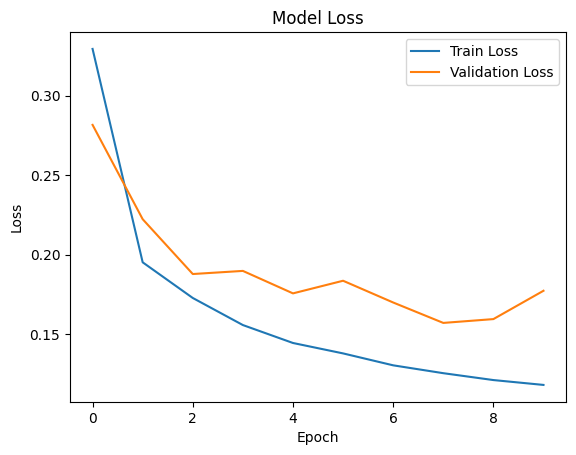

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


Step 8: Evaluation on Test Set

In [ ]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
loss, acc = model.evaluate(test_data)
print(f"Test Accuracy: {acc*100:.2f}%")

# Predict and Classification Report
predictions = (model.predict(test_data) > 0.5).astype("int32")
true_labels = test_data.classes

print(classification_report(true_labels, predictions, target_names=["Real", "Fake"]))


341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.9217 - loss: 0.1823
Test Accuracy: 89.00%
341/341 ━━━━━━━━━━━━━━━━━━━━ 10s 28ms/step
              precision    recall  f1-score   support

        Real       0.86      0.93      0.89      5492
        Fake       0.92      0.85      0.88      5413

    accuracy                           0.89     10905
   macro avg       0.89      0.89      0.89     10905
weighted avg       0.89      0.89      0.89     10905



Step 9: Confusion Matrix

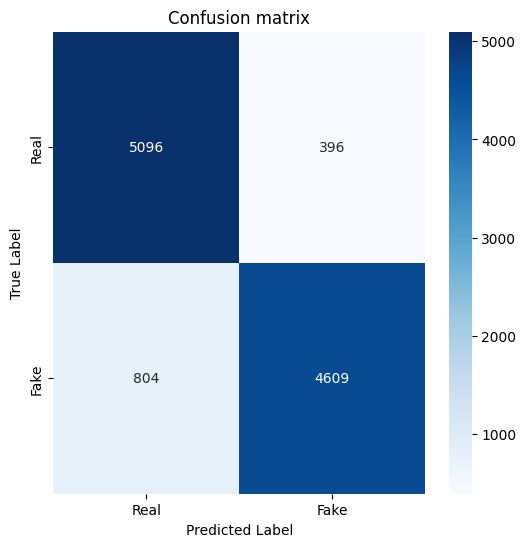

In [ ]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
                xticklabels=classes, yticklabels=classes)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title(title)
    plt.show()

cm = confusion_matrix(true_labels, predictions)
plot_confusion_matrix(cm, ["Real", "Fake"])
